### Table of Content 

- [The Matter graph](#The-Matter-graph)
- [Hide auto transitions](#Hide-auto-transitions)
- [Previous state and transition notation](#Previous-state-and-transition-notation)
- [One Machine and multiple models](#One-Machine-and-multiple-models)
- [Show only the current region of interest](#Show-only-the-current-region-of-interest)
- [Example graph from Readme.md](#Example-graph-from-Readme.md)
- [Custom styling](#Custom-styling)
- [Enum states](#Enum-states)

In [1]:
import os, sys, inspect, io

cmd_folder = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))

if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
    
from transitions import *
from transitions.extensions import GraphMachine
from IPython.display import Image, display, display_png


class Model():
    
    # graph object is created by the machine
    def show_graph(self, **kwargs):
        stream = io.BytesIO()
        self.get_graph(**kwargs).draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue()))

        
class Matter(Model):
    def alert(self):
        pass
    
    def resume(self):
        pass
    
    def notify(self):
        pass
    
    def is_valid(self):
        return True
    
    def is_not_valid(self):
        return False
    
    def is_also_valid(self):
        return True


extra_args = dict(initial='solid', title='Matter is Fun!',
                  show_conditions=True, show_state_attributes=True)

### The Matter graph

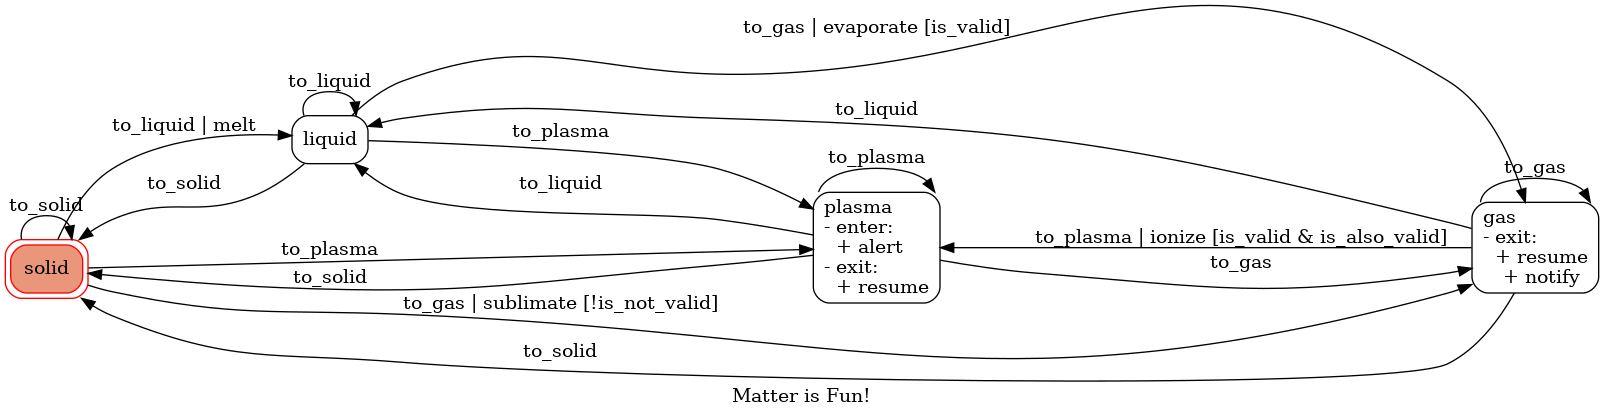

In [2]:
transitions = [
    { 'trigger': 'melt', 'source': 'solid', 'dest': 'liquid' },
    { 'trigger': 'evaporate', 'source': 'liquid', 'dest': 'gas', 'conditions':'is_valid' },
    { 'trigger': 'sublimate', 'source': 'solid', 'dest': 'gas', 'unless':'is_not_valid' },
    { 'trigger': 'ionize', 'source': 'gas', 'dest': 'plasma', 
      'conditions':['is_valid','is_also_valid'] }
]
states=['solid', 'liquid', {'name': 'gas', 'on_exit': ['resume', 'notify']},
        {'name': 'plasma', 'on_enter': 'alert', 'on_exit': 'resume'}]

model = Matter()
machine = GraphMachine(model=model, states=states, transitions=transitions, 
                       show_auto_transitions=True, **extra_args)
model.show_graph()

### Hide auto transitions

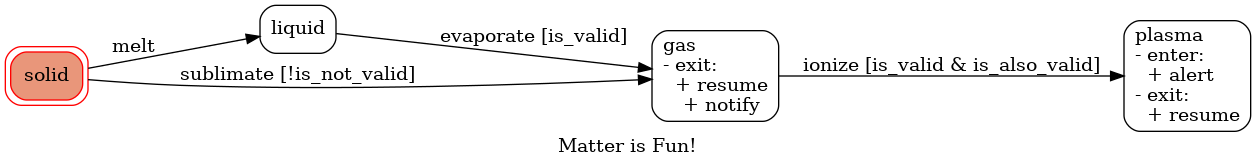

In [3]:
machine.auto_transitions_markup = False # hide auto transitions
model.show_graph(force_new=True) # rerender graph

### Previous state and transition notation

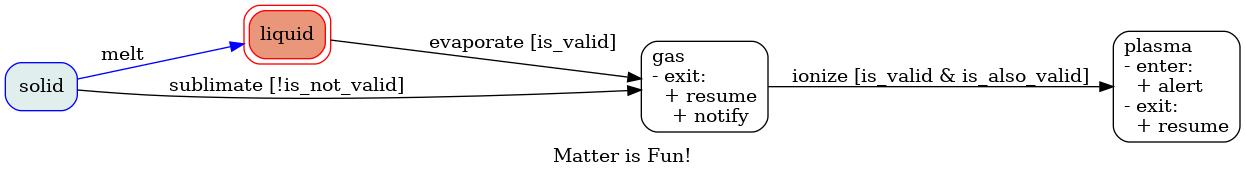

In [4]:
model.melt()
model.show_graph()

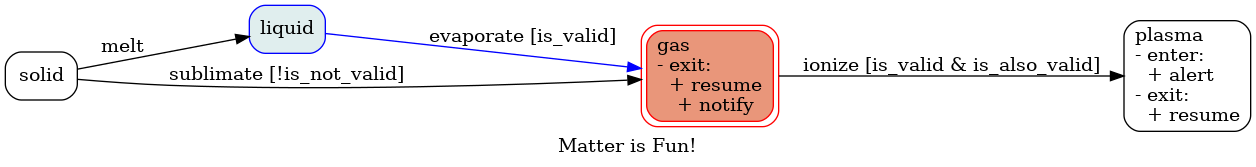

In [5]:
model.evaporate()
model.show_graph()

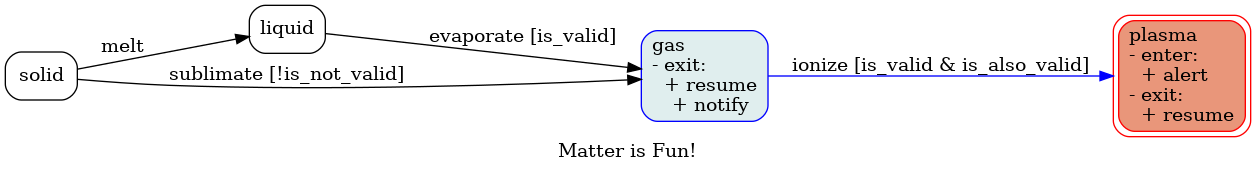

In [6]:
model.ionize()
model.show_graph()

### One Machine and multiple models

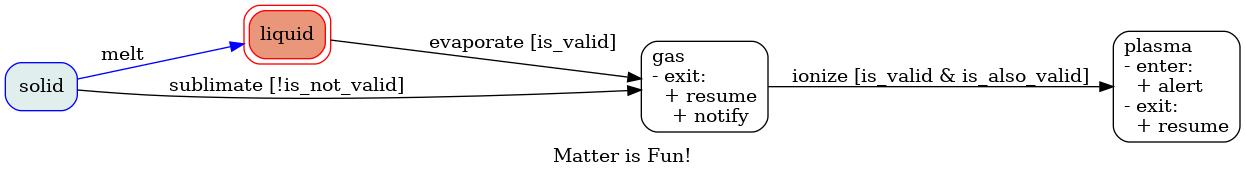

In [7]:
# multimodel test
model1 = Matter()
model2 = Matter()
machine = GraphMachine(model=[model1, model2], states=states, transitions=transitions, **extra_args)
model1.melt()
model1.show_graph()

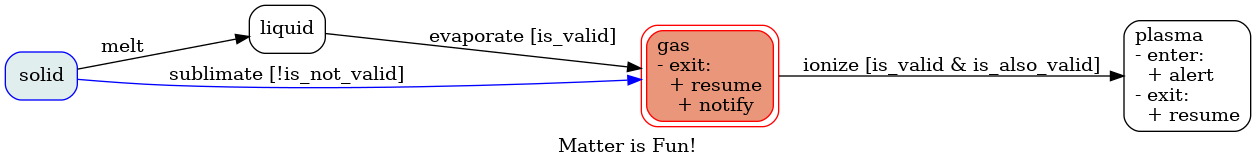

In [8]:
model2.sublimate()
model2.show_graph()

### Show only the current region of interest

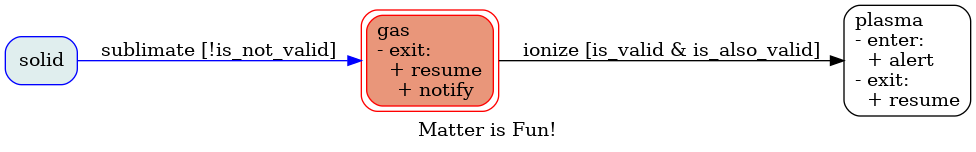

In [9]:
# show only region of interest which is previous state, active state and all reachable states
model2.show_graph(show_roi=True)

### Example graph from Readme.md

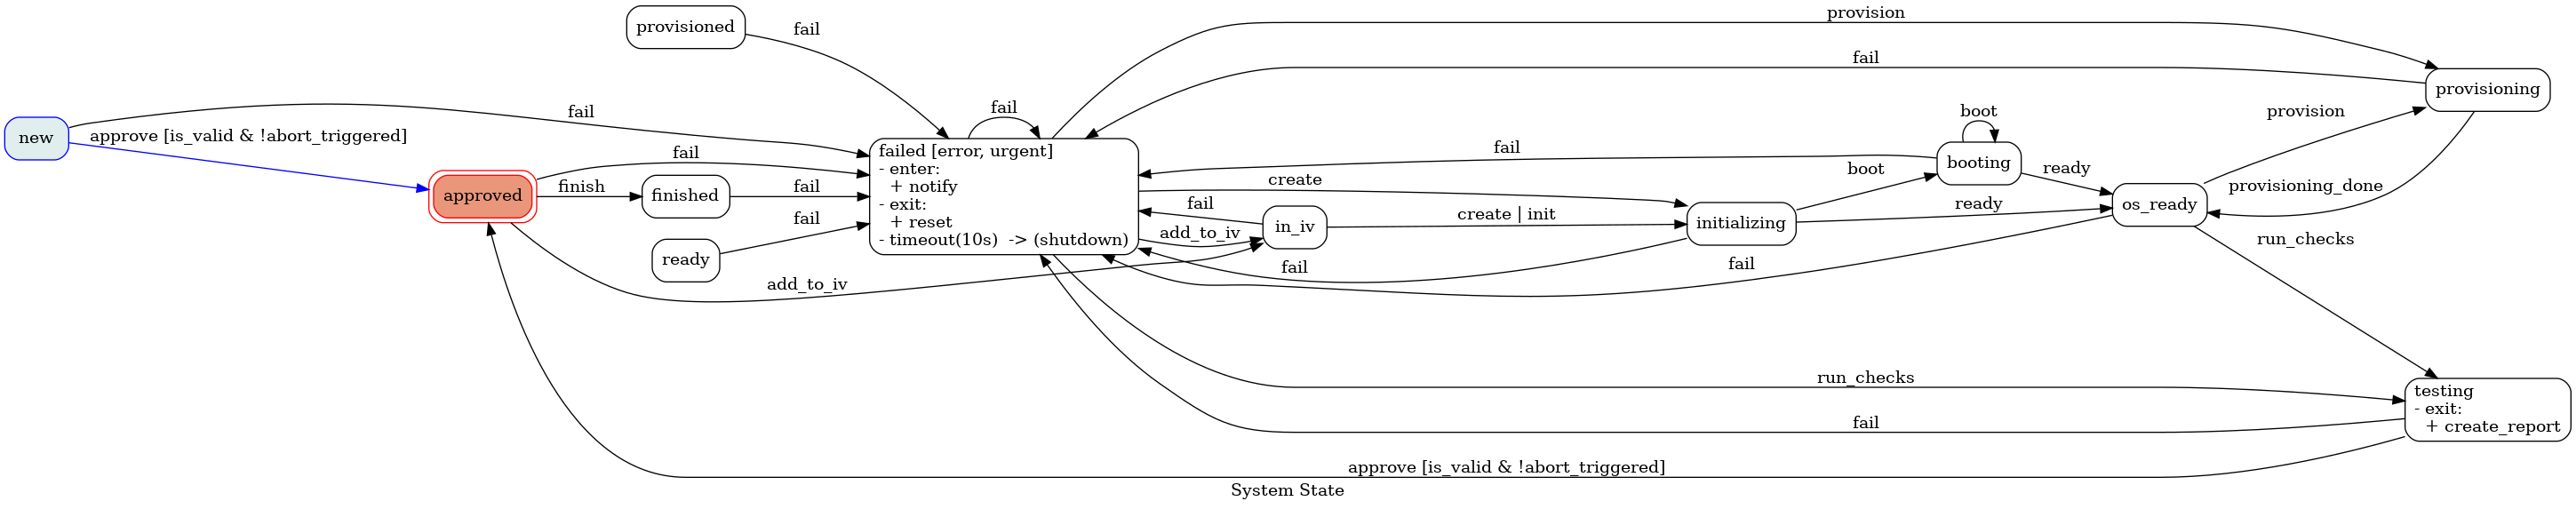

In [10]:
from transitions.extensions.states import Timeout, Tags, add_state_features

@add_state_features(Timeout, Tags)
class CustomMachine(GraphMachine):
    pass


states = ['new', 'approved', 'ready', 'finished', 'provisioned',
          {'name': 'failed', 'on_enter': 'notify', 'on_exit': 'reset',
           'tags': ['error', 'urgent'], 'timeout': 10, 'on_timeout': 'shutdown'},
          'in_iv', 'initializing', 'booting', 'os_ready', {'name': 'testing', 'on_exit': 'create_report'},
          'provisioning']

transitions = [{'trigger': 'approve', 'source': ['new', 'testing'], 'dest':'approved',
                'conditions': 'is_valid', 'unless': 'abort_triggered'},
               ['fail', '*', 'failed'],
               ['add_to_iv', ['approved', 'failed'], 'in_iv'],
               ['create', ['failed','in_iv'], 'initializing'],
               ['init', 'in_iv', 'initializing'],
               ['finish', 'approved', 'finished'],
               ['boot', ['booting', 'initializing'], 'booting'],
               ['ready', ['booting', 'initializing'], 'os_ready'],
               ['run_checks', ['failed', 'os_ready'], 'testing'],
               ['provision', ['os_ready', 'failed'], 'provisioning'],
               ['provisioning_done', 'provisioning', 'os_ready']]


class CustomModel(Model):
    def is_valid(self):
        return True
    
    def abort_triggered(self):
        return False


extra_args['title'] = "System State"
extra_args['initial'] = "new"
model = CustomModel()
machine = CustomMachine(model=model, states=states, transitions=transitions, **extra_args)
model.approve()
model.show_graph()

### Custom styling

The `GraphMachine` class uses its attributes `(hierarchical_)machine_attributes` and `style_attributes` to style (sub)graphs, nodes and edges.
You can edit them and add new entries to `style_attributes` to customized you graph's look.

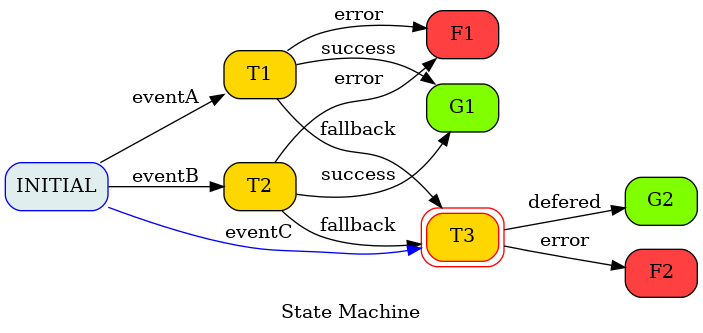

In [11]:
# thanks to @dan-bar-dov (https://github.com/pytransitions/transitions/issues/367)
model = Model()

transient_states = ['T1', 'T2', 'T3']
target_states = ['G1', 'G2']
fail_states = ['F1', 'F2']
transitions = [['eventA', 'INITIAL', 'T1'], ['eventB', 'INITIAL', 'T2'], ['eventC', 'INITIAL', 'T3'],
               ['success', ['T1', 'T2'], 'G1'], ['defered', 'T3', 'G2'], ['fallback', ['T1', 'T2'], 'T3'],
               ['error', ['T1', 'T2'], 'F1'], ['error', 'T3', 'F2']]

machine = GraphMachine(model, states=transient_states + target_states + fail_states,
                       transitions=transitions, initial='INITIAL', show_conditions=True,
                       show_state_attributes=True)

machine.machine_attributes['ratio'] = '0.471'
machine.style_attributes['node']['fail'] = {'fillcolor': 'brown1'}
machine.style_attributes['node']['transient'] = {'fillcolor': 'gold'}
machine.style_attributes['node']['target'] = {'fillcolor': 'chartreuse'}
model.eventC()

# customize node styling
for s in transient_states:
    machine.model_graphs[model].set_node_style(s, 'transient')
for s in target_states:
    machine.model_graphs[model].set_node_style(s, 'target')
for s in fail_states:
    machine.model_graphs[model].set_node_style(s, 'fail')

# draw the whole graph ...
model.show_graph()

### Enum states

Enum states can also be used with `GraphSupport`. Their labels will be defined by the enum field name.

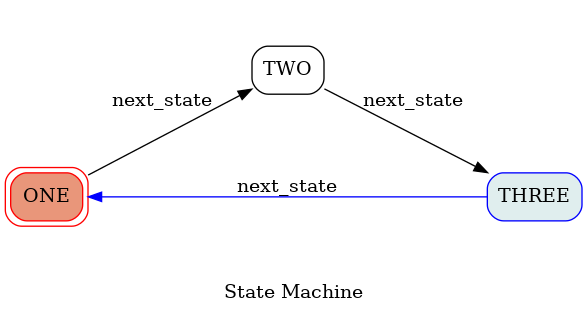

In [12]:
from enum import Enum, auto, unique

@unique
class States(Enum):
    
    ONE = auto()
    TWO = auto()
    THREE = auto()

model = Model()
machine = GraphMachine(model, states=States, auto_transitions=False, ordered_transitions=True, initial=States.THREE)
model.next_state()
model.show_graph()

### Editing the graph object directly

In case your needed changes are not supported out of the box, you can alter the graph object directly before drawing it.
The capabilities for direct graph editing depends on the backend you use.
`pygraphivz` allows to retrieve elements directly.
This becomes useful, when you for instance want to alter the node labels (maybe because you do not like the ALL CAPS labels generated when using enums).

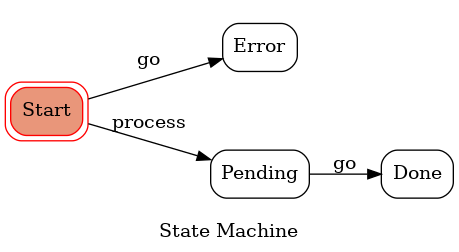

In [13]:
from transitions.extensions.diagrams import GraphMachine

states = ['A', 'B', 'C', 'D']
state_translations = {
    'A': 'Start',
    'B': 'Error',
    'C': 'Pending',
    'D': 'Done'
}

transitions = [['go', 'A', 'B'], ['process', 'A', 'C'], ['go', 'C', 'D']]

model = Model()
m = GraphMachine(model, states=states, transitions=transitions, initial='A')
graph = model.get_graph()

for node in graph.iternodes():
    node.attr['label'] = state_translations[node.attr['label']]

model.show_graph()